<div align="center" style="background-color:#f2f2f2; padding:10px; border-radius: 20px">
  <h1 style="color:#990000; font-size: 40px; font-weight: bold;">Real or Fake News Detection 📰</h1>
</div>

<div style="text-align:center; margin-top: 20px; margin-bottom: 20px">
  <img src="https://www.riddle.com/imageservice/q_80,f_auto,c_fill,w_960,h_540/fntw1vuzhdr6hijqcsbz" alt="r/f" style="border-radius: 15px;">
</div>

In this notebook, we'll embark on the exciting journey of classifying news articles as either "real" or "fake" using powerful Natural Language Processing (NLP) techniques. Our dataset is split into two parts: `Fake.csv` and `True.csv`. Initially, we'll merge these two files to create our working dataset. In this combined dataset, we'll assign the label 1 to represent "real" news and 0 to represent "fake" news.

To tackle this classification task, we'll be using a powerful tool called the BiDirectional Long Short-Term Memory (BiLSTM) model. It excels at understanding the meaning of words in a sentence. Additionally, we'll utilize GloVe word embeddings, which will help the model understand word context better. With these tools, we'll analyze news articles and determine which ones are real and which ones are fake.

Let's dive in! 💻🚀

## Importing the Dependencies 📚

Let's start with importing the necessary dependencies for our analysis and model building process. 🚀

In [1]:
import os
import warnings

#--------------------------------------------------------------------------------------#

import numpy as np
import pandas as pd

#--------------------------------------------------------------------------------------#

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#--------------------------------------------------------------------------------------#

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

#--------------------------------------------------------------------------------------#

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             classification_report, ConfusionMatrixDisplay)

#--------------------------------------------------------------------------------------#

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#--------------------------------------------------------------------------------------#

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2024-05-01 14:03:10.398202: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 14:03:10.398295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 14:03:10.576613: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(f'Tensorflow Version: {tf.__version__}')
print("GPU Available:", tf.config.list_physical_devices('GPU')[0])

Tensorflow Version: 2.15.0
GPU Available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-05-01 14:03:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-05-01 14:03:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-05-01 14:03:23--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [4]:
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def text_cleaner(text):
    text = text.lower()
    
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'https?://\S+|www\.\S+|[^a-zA-Z\s]', '', text)
    text = re.sub(r'<.*?>', '', text)
    
    return text

def text_preprocessor(text):
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

# Data Preprocessing and Visualization 📊🔍¶

In this section, we'll preprocess the data and visualize it to gain insights before moving forward with model building.

## Importing the Dataset 📥

Let's begin by importing the dataset that we'll be working with. 📊

In [5]:
# load the true and fake news dataset

true = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')['text']
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')['text']

true_df = pd.DataFrame({'text': true, 'label': 1})
fake_df = pd.DataFrame({'text': fake, 'label': 0})

# concatenate both dataset and shuffle the rows

df = pd.concat([true_df, fake_df], ignore_index = True).sample(frac = 1).reset_index(drop = True)

# display the dataset

df.head()

,text,label
0,Donald Trump s attacks on the free press conti...,0
1,Is CNN contributor and Democratic Strategist B...,0
2,HOUSTON (Reuters) - A suspicious substance fou...,1
3,Hillary pretends to care about the Black commu...,0
4,Acting Attorney General Sally Yates refused to...,0


## Exploratory Visualizations 📊

In this section, we'll explore various visualizations to gain insights into our dataset. 📈

### Label Distribution 📊

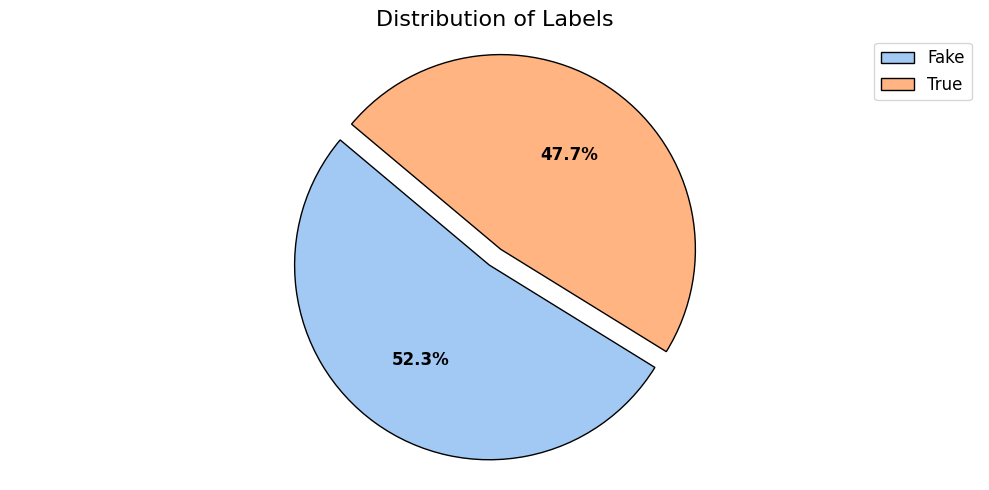

In [6]:
fig, ax = plt.subplots(figsize = (10, 5))

labels = ['Fake', 'True']
sizes = df['label'].value_counts().values
colors = sns.color_palette('pastel')

wedges, texts, autotexts = ax.pie(sizes, colors = colors, 
                                  autopct = '%1.1f%%', startangle = 140, 
                                  explode = (0.1, 0), wedgeprops = dict(edgecolor = 'black'))

ax.set_title('Distribution of Labels', fontsize = 16)
ax.axis('equal') 
ax.legend(wedges, labels, loc = "best", fontsize = 12)

for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

### Word Clouds ☁️

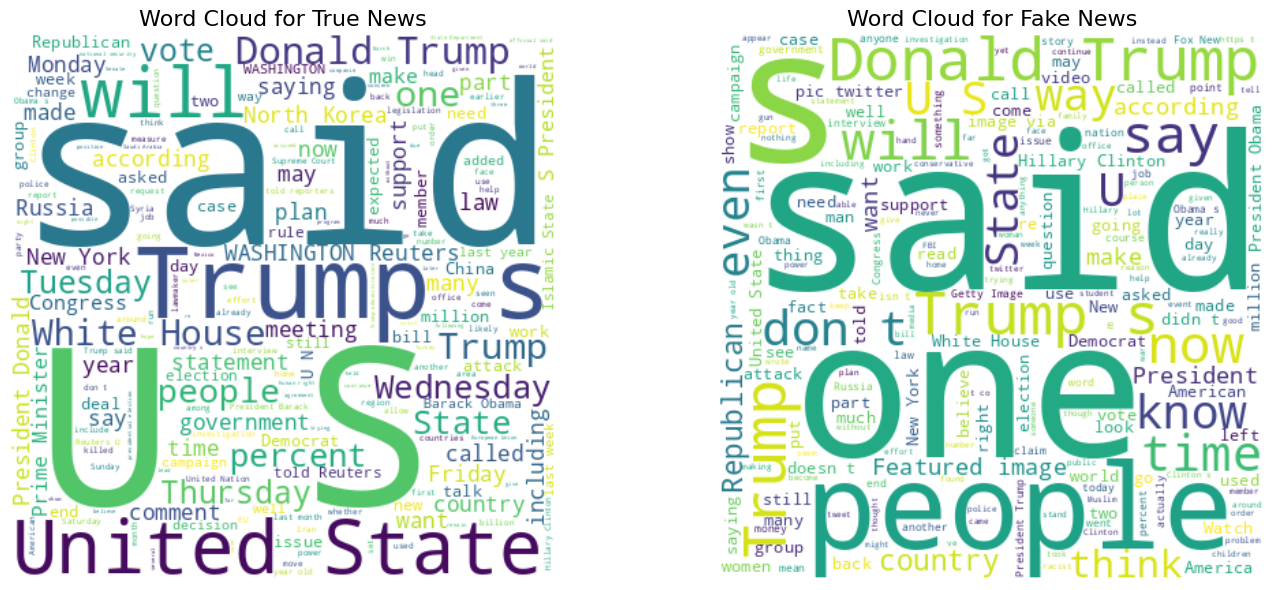

In [7]:
true_news_data = df[df['label'] == 1]['text'].values
fake_news_data = df[df['label'] == 0]['text'].values

all_true_news = ' '.join(true_news_data)
all_fake_news = ' '.join(fake_news_data)

wordcloud_true = WordCloud(width = 400, height = 400, 
                          background_color = 'white').generate(all_true_news)
wordcloud_fake = WordCloud(width = 400, height = 400, 
                           background_color = 'white').generate(all_fake_news)

plt.figure(figsize = (15, 6))

# true news

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_true, interpolation = 'bilinear')
plt.title('Word Cloud for True News', fontsize = 16)
plt.axis('off')

# fake news

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_fake, interpolation = 'bilinear')
plt.title('Word Cloud for Fake News', fontsize = 16)
plt.axis('off')

plt.tight_layout()
plt.show()

### News Length Distribution 📊

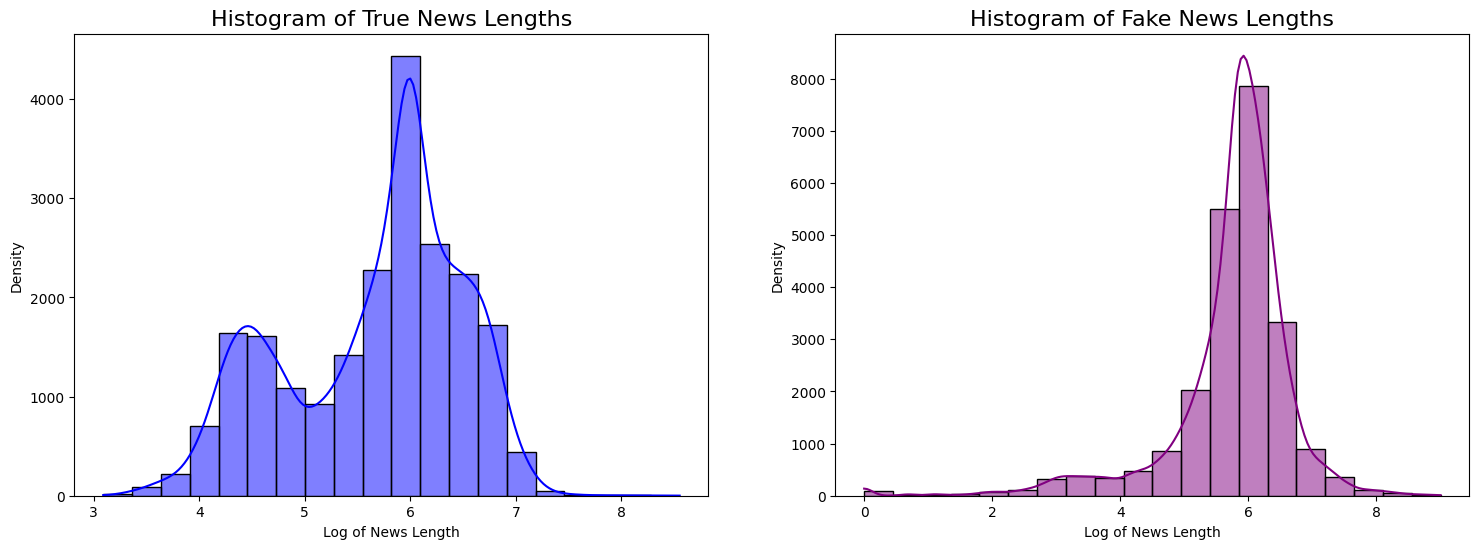

In [8]:
fake_lengths = np.log([len(news.split()) for news in df[df['label'] == 0]['text']])
true_lengths = np.log([len(news.split()) for news in df[df['label'] == 1]['text']])

fig, axes = plt.subplots(1, 2, figsize = (18, 6))

# true news

sns.histplot(true_lengths, bins = 20, color = 'blue', kde = True, ax = axes[0])
axes[0].set_title('Histogram of True News Lengths', fontsize = 16)
axes[0].set_xlabel('Log of News Length')
axes[0].set_ylabel('Density')

# fake news

sns.histplot(fake_lengths, bins = 20, color = 'purple', kde = True, ax = axes[1])
axes[1].set_title('Histogram of Fake News Lengths', fontsize = 16)
axes[1].set_xlabel('Log of News Length')
axes[1].set_ylabel('Density')

plt.show()

## Data Preprocessing 🛠️

In this section, we'll preprocess our data to prepare it for model training. 📝

In [9]:
%%time

# clean and preprocess the dataset

df['text'] = df['text'].apply(lambda x: text_cleaner(x))
df['text'] = df['text'].apply(lambda x: text_preprocessor(x))

# display the preprocessed dataset

df.head()

CPU times: user 3min 57s, sys: 141 ms, total: 3min 57s
Wall time: 3min 57s


,text,label
0,donald trump attack free press continu get wor...,0
1,cnn contributor democrat strategist bob beckel...,0
2,houston reuter suspici substanc found houston ...,1
3,hillari pretend care black communiti care much...,0
4,act attorney general salli yate refus back don...,0


In [10]:
# split the dataset

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = ['label']), 
                                                    df['label'], 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# print the shape of train/test features and labels

print(f'\nShape of Training Features (X_train) --> {X_train.shape} and \
Training Labels (y_train) --> {y_train.shape}')

print(f'\nShape of Testing Features (X_train) --> {X_test.shape} and \
Testing Labels (y_test) --> {y_test.shape}')


Shape of Training Features (X_train) --> (35918, 1) and Training Labels (y_train) --> (35918,)

Shape of Testing Features (X_train) --> (8980, 1) and Testing Labels (y_test) --> (8980,)


In [11]:
# initialize the tokenizer and fit on training data

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['text'])

# tokenize the train and the test data

train_seq = tokenizer.texts_to_sequences(X_train['text'])
test_seq = tokenizer.texts_to_sequences(X_test['text'])

vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(sequence) for sequence in train_seq)

# pad the sequences

train_seq = pad_sequences(train_seq, maxlen = max_length, padding = 'post', truncating = 'post')
test_seq = pad_sequences(test_seq, maxlen = max_length, padding = 'post', truncating = 'post')

# Developing the Classification Model 💻

In this section, we'll focus on developing our classification model for news categorization. We'll leverage the 300-dimensional GloVe embeddings for our text representation. 📈

In [12]:
glove_emb = '/kaggle/working/glove.6B.300d.txt'

epochs = 10
lr = 1e-3

embedding_dim = 300
embeddings_index = {}

f = open(glove_emb)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
# define the model

model = Sequential([
    Input(shape = (max_length,)),
    Embedding(vocab_size, embedding_dim, input_length = max_length, trainable = False),
    
    Bidirectional(LSTM(128, return_sequences = True)),
    Bidirectional(LSTM(64)),
    Dropout(0.2),
    
    Dense(256, activation = 'relu'),
    Dropout(0.5),
    
    Dense(1, activation = 'sigmoid')
])

# set the embedding weights

model.layers[0].set_weights([embedding_matrix])

# compile the model

model.compile(optimizer = Adam(learning_rate = lr), 
              loss = BinaryCrossentropy(), metrics = ['accuracy'])

# print model summary

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 4975, 300)      │    24,428,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 4975, 256)      │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,065,029 (95.62 MB)

 Trainable params: 636,929 (2.43 MB)

 Non-trainable params: 24,428,100 (93.19 MB)

In [14]:
%%time

# define callbacks

model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')

# train the model

history = model.fit(train_seq, y_train, epochs = epochs, 
                    validation_split = 0.2, callbacks = [model_es, model_rlr])

Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 602s 664ms/step - accuracy: 0.9863 - loss: 0.0609 - val_accuracy: 0.9987 - val_loss: 0.0065 - learning_rate: 0.0010
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 599s 667ms/step - accuracy: 0.9987 - loss: 0.0060 - val_accuracy: 0.9992 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 596s 663ms/step - accuracy: 0.9988 - loss: 0.0045 - val_accuracy: 0.9982 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 595s 662ms/step - accuracy: 0.9994 - loss: 0.0022 - val_accuracy: 0.9997 - val_loss: 0.0021 - learning_rate: 2.0000e-04
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 594s 662ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9996 - val_loss: 0.0023 - learning_rate: 2.0000e-04
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 594s 662ms/step - accuracy: 0.9999 - loss: 8.1881e-04 - val_accuracy: 0.9997 - val_loss: 0.0023 - learning_rate: 4.0000e-05
CPU times: user 53min 19s, sys: 5min 47s, total:

In [15]:
# get predictions

y_pred_train = np.round(model.predict(train_seq, verbose = 0))
y_pred_test = np.round(model.predict(test_seq, verbose = 0))

# Evaluating the Classifier 📊

In this section, we'll assess the performance of our email classification model. 📈

In [16]:
# display the accuracy

print(f'Train Accuracy : {accuracy_score(y_train, y_pred_train) * 100:.2f} %')
print(f'Test Accuracy  : {accuracy_score(y_test, y_pred_test) * 100:.2f} %')

Train Accuracy : 99.97 %
Test Accuracy  : 99.91 %


In [17]:
# display classification report

print(f'Classification Report (Train) : \n\n{classification_report(y_train, y_pred_train)}')
print('-----------------------------------------------------')
print(f'\nClassification Report (Test)  : \n\n{classification_report(y_test, y_pred_test)}')

Classification Report (Train) : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18784
           1       1.00      1.00      1.00     17134

    accuracy                           1.00     35918
   macro avg       1.00      1.00      1.00     35918
weighted avg       1.00      1.00      1.00     35918

-----------------------------------------------------

Classification Report (Test)  : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4697
           1       1.00      1.00      1.00      4283

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



## Evaluation Visualization 📊

Here, we'll visualize the evaluation metrics to gain insights into our classifier's performance. 📈

### Accuracy and Loss Curve 📈

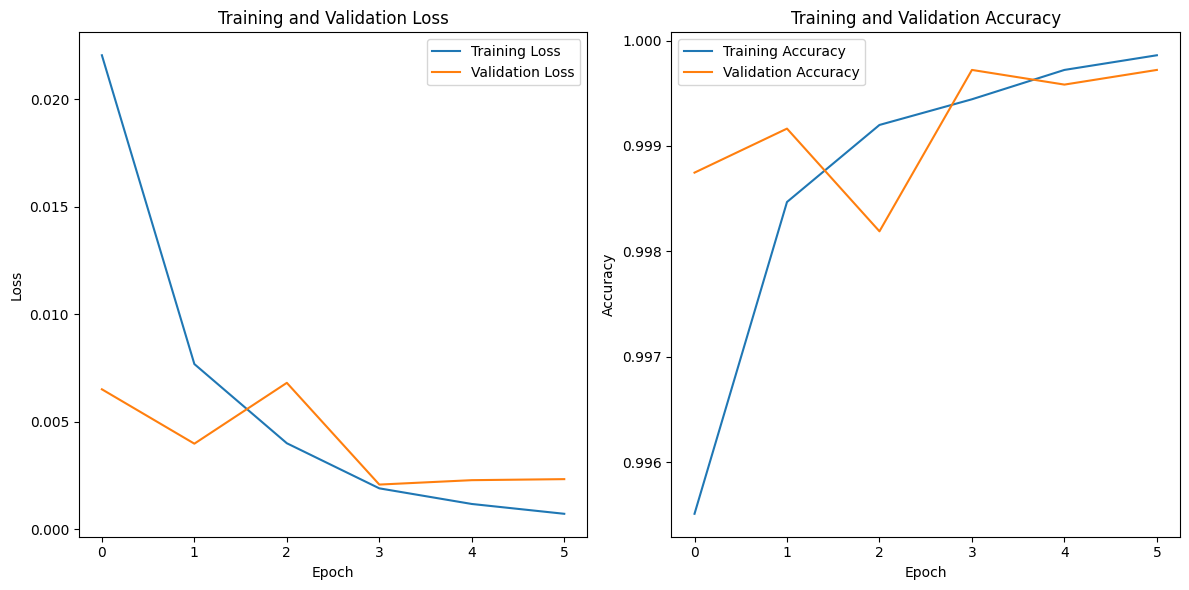

In [18]:
plt.figure(figsize = (12, 6))

# loss plot

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# accuracy plot

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Confusion Matrix 📊

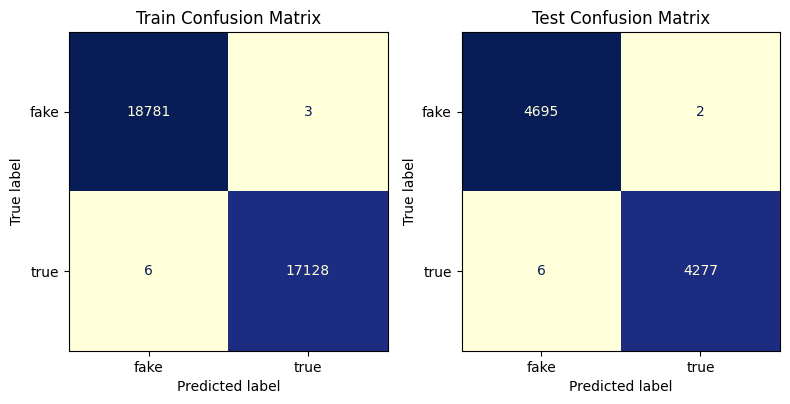

In [19]:
train_matrix = confusion_matrix(y_train, y_pred_train)
test_matrix = confusion_matrix(y_test, y_pred_test)

class_labels = ['fake', 'true']

disp_train = ConfusionMatrixDisplay(confusion_matrix = train_matrix, display_labels = class_labels)
disp_test = ConfusionMatrixDisplay(confusion_matrix = test_matrix, display_labels = class_labels)

fig, axs = plt.subplots(1, 2, figsize = (8, 12))

# train

disp_train.plot(ax = axs[0], cmap = 'YlGnBu', colorbar = False)
axs[0].set_title('Train Confusion Matrix')

# test

disp_test.plot(ax = axs[1], cmap = 'YlGnBu', colorbar = False)
axs[1].set_title('Test Confusion Matrix')

plt.tight_layout()
plt.show()

The results are indeed impressive! Tweaking the model further could potentially decrease our **False Positives (FP)** and **False Negatives (FN)** even more. 😊👍

**Thank you for reviewing my notebook! If you found it helpful, I'd appreciate an upvote.** 😄